##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
SPDX-License-Identifier: Apache-2.0

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



##### Instructions to run on Colab:.

1. Run the cell below to install dependencies and then _restart the runtime_.
2. Continue from the cell after that in the new runtime.



In [1]:
#@title Click Install dependencies.
!pip install http://download.pytorch.org/whl/cpu/torch-0.4.1-cp36-cp36m-linux_x86_64.whl  # PyTorch
!pip install -e git+https://github.com/zafarali/emdp.git#egg=emdp --user  # MDP Simulator

    100% |████████████████████████████████| 91.1MB 38.6MB/s 
Obtaining emdp from git+https://github.com/zafarali/emdp.git#egg=emdp
  Cloning https://github.com/zafarali/emdp.git to ./src/emdp
  Running setup.py develop for emdp


##### Library of tools to simplify experiments

In [11]:
#@title Run to initialize a small library of components to simplify experiments.
%pylab inline
import copy
import io
import json

import numpy as np
import seaborn as sns
import torch
from torch import nn
from torch import autograd

from emdp import examples
from emdp import actions
from emdp import analytic

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

class Policy(nn.Module):
  def __init__(self, state_space, action_space, mix_coeff=0.0):
    """A simple linear policy.
    Args:
      state_space: An int representing the size of the input vectors.
      action_space: An int representing the number of available actions.
      mix_coeff: Controls the stochasticity of the policy.
    """
    super().__init__()
    self.linear = nn.Linear(state_space, action_space)
    self.softmax = nn.Softmax(1)
    self.mix_coeff = mix_coeff
    self.action_space = action_space

  def forward(self, states):
    """Returns a probabilities over actions for a batch of states
    
    Args:
      states: torch.FloatTensor shape |B| x |S|
    
    Returns:
      actions: torch.FloatTensor of shape |B| x |A| representing the probability
        of taking each action in a state of the batch.
    """
    logits = self.linear(states)
    probs = self.softmax(logits)
    scaled_probs = (1-self.mix_coeff) * probs
    unif_probs = self.mix_coeff * 1/self.action_space
    mixed_probs = scaled_probs + unif_probs
    return mixed_probs



class History(object):
  """Store data about training."""

  def __init__(self):
    self.history = {
      'true_objective':[],
      'opt_objective':[],
      'update':[],
      'mean_ent': []
    }
  def update(self, i, true, opt, ent):
    self.history['true_objective'].append(true)
    self.history['opt_objective'].append(opt)
    self.history['update'].append(i)
    self.history['mean_ent'].append(ent)


def evaluate_policy(grid_world, policy, w_reward=1.0, w_ent=0.0):
  """Evaluates the policy exactly.
  
  Args:
    grid_world: The empd.MDP with accessible transition dynamics.
    policy: A torch nn.Module that returns a softmax over actions given state.
    w_reward: A float weighting for the reward term.
    w_ent: A float weighting for the entropy term.

  Returns:
    The exact expected discounted return.
  """
  with torch.no_grad():
    pi = policy(torch.eye(mdp.state_space)).detach().numpy()
    H = (-pi*np.log(pi)).sum(1).reshape(-1, 1)
    augmented_reward = w_reward * mdp.R + w_ent * H
    return (
      analytic.calculate_V_pi(
        mdp.P, augmented_reward , pi, mdp.gamma) * mdp.p0).sum()

def interpolate_between_policy_parameters(
  start_params,
  end_params,
  grid_world,
  policy,
  alpha_start=-0.5,
  alpha_end=1.5,
  n_alphas=50,
  w_ent=0.0):
  """Interpolates between policy parameters for a gridworld.
  
  Args:
    start_params: The flattened starting parameter vector.
    end_params: The flattened ending parameter vector.
    grid_world: The emdp.MDP with accessible transition dynamics.
    policy: A torch nn.Module whose parameters can be reset. Note that this will
      overwrite the policy so it is best to make a copy using `copy.deepcopy`.
    alpha_start: The float starting point for the interpolation.
    alpha_end: The float ending point for the interpolation.
    n_alphas: The number of points between the starting and ending points to do
      the interpolations in between.
    w_ent: The weighting for the entropy term.
  
  Returns:
    alphas: The points along the interpolation at which evaluations were made.
    E_vpi: The true expected discounted reward (no weighting term).
    E_vpi_regularized: The entropy agumented discounted reward.
    E_vpi_ent_only: The expected discounted entropy.
  """

  alphas = []
  E_vpi = []
  E_vpi_regularized = []
  E_vpi_ent_only = []
  for alpha in np.linspace(alpha_start, alpha_end, n_alphas):
    params = (1 - alpha) * start_params + alpha * end_params
    if isinstance(params, np.ndarray):
      params = torch.FloatTensor(params)
    nn.utils.vector_to_parameters(params, policy.parameters())
    try:
      alphas.append(alpha)
      V_pi = evaluate_policy(
        grid_world, policy, w_reward=1.0, w_ent=0.0)
      E_vpi.append(V_pi)

      V_pi_reg = evaluate_policy(
        grid_world, policy, w_reward=1.0, w_ent=w_ent)
      E_vpi_regularized.append(V_pi_reg)
      
      V_vpi_ent_only = evaluate_policy(
        grid_world, policy, w_reward=0.0, w_ent=w_ent)
      E_vpi_ent_only.append(V_vpi_ent_only)

    except np.linalg.linalg.LinAlgError as e:
      print('LinAlgError: {} for {}. Skipping this.'.format(e, alpha))
      continue

  alphas = np.array(alphas)
  E_vpi = np.array(E_vpi)
  E_vpi_regularized = np.array(E_vpi_regularized)
  E_vpi_ent_only = np.array(E_vpi_ent_only)
  return alphas, E_vpi, E_vpi_regularized, E_vpi_ent_only


def train(
  mdp,
  policy, 
  learn_updates=500,
  w_reward=1.0,
  w_ent=0.0,
  w_ent_decay=1.0,
  print_interval=10,
  step_size=0.1,
  update_counts=0,
  history=None):
  """Trains a policy in an mdp using gradient ascent.

  Args:
    mdp: The emdp.MDP to train on. 
    policy: The nn.Module that represents the policy.
    learn_updates: The number of updates to train for.
    w_reward: A float weighting for the reward term.
    w_ent: A float weighting for the entropy term.
    w_ent_decay: A float <=1.0 representing how much to decay the w_ent term at
      every update.
    print_interval: The number of intervals after which to print.
    step_size: The step size for the updates.
    update_counts: An integer representing what number to start the counting at.
      Use this to continue learning.
    history: A History object. Use only when continuing the learning process.

  Returns:
    history: A History object containing learning curves.
  """
  if history is None:
    history = History()
  else:
    update_counts = history.history['update'][-1]
  
  for i in range(learn_updates):
    true_obj_val = evaluate_policy(mdp, policy)
    policy.zero_grad()
    
    # Glossary of terms and shapes.
    # Probability for each action in each state:
    pi = policy(torch.eye(mdp.state_space))  # |S| x |A|.

    # Reward for each action in each state:
    mdp.R  # |S| x |A|.

    # Transition probability for going from s to s' by taking action a:
    mdp.P  # |S| x |A| x |S|.

    # Entropy for the probability at each state.
    H = (-pi*pi.log()).sum(1)  # |S|, 

    # Augmented reward for each action in each state.
    augmented_reward = (
      w_reward * mdp.R + w_ent * H.detach().numpy().reshape(-1, 1))  # |S| x |A|

    # A numpy representation of the policy (to detach gradients from graph.)
    pi_numpy = pi.detach().numpy()

    # We use emdp.analytic library to compute analytic things.
    # Expected transition matrix.
    P_pi = analytic.calculate_P_pi(mdp.P, pi_numpy)  # |S| x |S| 

    # Discounted state occupancy of going from any s to s', (I-gamma * P_pi)^-1.
    Phi = analytic.calculate_successor_representation(
      P_pi, mdp.gamma)  # |S| x |S|  
    
    # Expected reward for transitioning from a state.
    R_pi = analytic.calculate_R_pi(augmented_reward, pi_numpy)  # |S|

    # Expected discounted return from a given state.
    V_pi = analytic.calculate_V_pi_from_successor_representation(
      Phi, R_pi)  # |S|, 

    #  The state-action values.
    Q_pi = (
      augmented_reward + mdp.gamma * np.einsum(
        'sat,t->sa', mdp.P, V_pi))  # |S| x |A|
    
    # Sanity check:
    assert np.allclose(np.einsum('sa,sa->s', pi_numpy, Q_pi), V_pi), \
    'Q averaged over all actions is equal to V.'
    # Discounted state occupancy from the initial state.
    d_pi = Phi[mdp.p0.argmax()]
    
    # Do some bookkeeping.
    mean_ent = H.mean()
    opt_obj_val = (mdp.p0 * V_pi).sum()
    if i % print_interval == 0:
      print('updates: {}, true: {:.3f} opt: {:.3f} mean_ent: {:.3f}'.format(
        update_counts, true_obj_val, opt_obj_val, mean_ent))
    history.update(update_counts, true_obj_val, opt_obj_val, mean_ent)

    # Float casting to make sure we do not differentiate through these.
    d_pi_torch = torch.FloatTensor(d_pi)
    pi_detached = torch.FloatTensor(pi_numpy)

    # Now calculating the loss function suitable for autodiff.
    autodiff_surrogate_per_state_action = (
      pi.log() * torch.FloatTensor(Q_pi) + (w_ent * H).view(-1, 1))
    autodiff_surrogate_per_state = torch.einsum(
      'sa,sa->s', (pi_detached, autodiff_surrogate_per_state_action))
    autodiff_surrogate = torch.einsum(
      's,s->', (d_pi_torch, autodiff_surrogate_per_state))
    # print('surrogate:{}'.format(autodiff_surrogate))
    gradients = autograd.grad(
      autodiff_surrogate, policy.parameters(), retain_graph=True)

    # Apply gradient updates:
    for g, p in zip(gradients, policy.parameters()):
      p.data.add_(step_size * g)
    update_counts += 1

    # Decay the entropy.
    if w_ent_decay < 1:
      w_ent = w_ent * w_ent_decay
  return history





Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Experiment: Exploring the impact of entropy regularization in the exact gradient setting.

We are interested in knowing a few things:

1. Is high variance the main issue with policy learning?
2. Does entropy regularization help find better policies?
3. Why does it help?

In [3]:
# Make the required grid world as explained in the manuscript.
eps = 0.9
best_reward = 5.0
grid_size = 5
mdp, reward_spec = examples.tricky_gridworlds.make_symmetric_epsilon_reward_env(
  eps, best_reward=best_reward, size=grid_size)

# Print out values for crosscheck.
# These values are what our optimization algorithm should find.
print('best possible return is {}'.format(
  np.max(mdp.R) * mdp.gamma ** (mdp.size-1)))
print('suboptimal return is {}'.format(
  np.min(mdp.R[np.nonzero(mdp.R)]) * mdp.gamma ** (mdp.size-1)))

best possible return is 4.8029800499999995
suboptimal return is 4.322682045


## Training without entropy regularization.

Use this to get a count of the number of suboptimal policies found. Also keep track of the seeds which produce suboptimal policies so that we can try those under entropy regularization.

In [0]:
w_ent = 0.0  # Entropy coefficient.
w_r = 1.0  # Reward weight.
histories = []
step_size = 0.1
learn_updates = 1500
final_returns = []
for i in range(5,6):
  print('Run {}'.format(i))
  torch.manual_seed(i)  # Set the seed for reproducible runs.
  policy = Policy(mdp.state_space, mdp.action_space)
  histories.append(
    train(mdp, policy, learn_updates=learn_updates, w_ent=w_ent, w_reward=w_r,
          step_size=step_size, print_interval=learn_updates-1))
  final_returns.append(histories[-1].history['true_objective'][-1])

In [0]:
plt.hist(final_returns)
plt.title('Distribution of policy returns.')
plt.xlabel('Return')
plt.ylabel('Count')

## Training with entropy regularization.

In [0]:
#@title Use sliders to easily change parameters.
w_ent = 0 #@param {type:"slider", min:0, max:5, step:0.1}
w_r = 1.0  # Reward weight.
histories_regularized = []
step_size = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}
w_ent_decay = 1.0 #@param {type:"slider", min:0, max:1, step:0.01}
final_returns_regularized = []

for i in range(20):
  print('Run {}'.format(i))
  torch.manual_seed(i)  # Set the seed for reproducible runs.
  policy = Policy(mdp.state_space, mdp.action_space)
  histories.append(
    train(
      mdp, policy, learn_updates=learn_updates,
      w_ent=w_ent, w_reward=w_r, w_ent_decay=w_ent_decay,
      step_size=step_size, print_interval=learn_updates-1))
  final_returns_regularized.append(
    histories_regularized[-1].history['true_objective'][-1])

## Linear Interpolations


### Interpolating Deterministic policies

In [0]:
policy = Policy(mdp.state_space, mdp.action_space)

# Get the policy that goes all right by setting the logits:
params_deterministic_right = torch.ones(mdp.action_space, mdp.state_space) * -20
params_deterministic_right[actions.RIGHT] = 0
bias = torch.zeros(mdp.action_space)

right_policy = copy.deepcopy(policy)
for to_set, p in zip(
  [params_deterministic_right, bias], right_policy.parameters()):
  p.data.set_(to_set)

# Get the policy that goes all right by setting the logits:
params_deterministic_down = torch.ones(mdp.action_space, mdp.state_space) * -20
params_deterministic_down[actions.DOWN] = 0
bias = torch.zeros(mdp.action_space)
down_policy = copy.deepcopy(policy)
for to_set, p in zip(
  [params_deterministic_down, bias], down_policy.parameters()):
  p.data.set_(to_set)

# Detach and numpy to get copies.
down_parameters = nn.utils.parameters_to_vector(
  down_policy.parameters()).detach().numpy()
right_parameters = nn.utils.parameters_to_vector(
  right_policy.parameters()).detach().numpy()

In [0]:
mix_coefficient = 0.43 #@param {type:"slider", min:0, max:1, step:0.01}
policy = Policy(mdp.state_space, mdp.action_space, mix_coefficient=1.0)

alphas, Vpi, Vpi_reg, V_pi_ent = interpolate_between_policy_parameters(
  down_parameters,
  right_parameters,
  mdp,
  policy,
  alpha_start=-0.0,
  alpha_end=1.0,
  n_alphas=100,
  w_ent=0.05
)
plt.plot(alphas, Vpi, label=r'$\tau=0.0$')
plt.plot(alphas, Vpi_reg, label=r'$\tau=0.05$')

alphas, _, Vpi_reg, _ = interpolate_between_policy_parameters(
  down_parameters,
  right_parameters,
  mdp,
  policy,
  alpha_start=-0.0,
  alpha_end=1.0,
  n_alphas=100,
  w_ent=0.01
)
plt.plot(alphas, Vpi_reg, label=r'$\tau=0.01$')


alphas, Vpi, Vpi_reg, V_pi_ent = interpolate_between_policy_parameters(
  down_parameters,
  right_parameters,
  mdp,
  policy,
  alpha_start=-0.0,
  alpha_end=1.0,
  n_alphas=100,
  w_ent=0.001
)
plt.plot(alphas, Vpi_reg, label=r'$\tau=0.001$')


alphas, Vpi, Vpi_reg, V_pi_ent = interpolate_between_policy_parameters(
  down_parameters,
  right_parameters,
  mdp,
  policy,
  alpha_start=-0.0,
  alpha_end=1.0,
  n_alphas=100,
  w_ent=0.1
)
plt.plot(alphas, Vpi_reg, label=r'$\tau=0.1$')


alphas, Vpi, Vpi_reg, V_pi_ent = interpolate_between_policy_parameters(
  down_parameters,
  right_parameters,
  mdp,
  policy,
  alpha_start=-0.0,
  alpha_end=1.0,
  n_alphas=100,
  w_ent=0.5
)
plt.plot(alphas, Vpi_reg, label=r'$\tau=0.5$')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel('Discounted Return')
# plt.semilogy()
plt.title('{}x{}, eps={}'.format(mdp.size, mdp.size, eps))
plt.ylim(0, 7.)
# plt.semilogy()

### Interpolating parameters found during optimization

Here we supplied pre-trained parameters. Alternatively, you can train parameters from above and use `nn.utils.parameters_to_vector` to get the parameters.

#### Preloaded:

In [0]:
# Paste the string here:
trained_parameters = json.loads('{"starting_parameters": [0.12953545153141022, -0.14665135741233826, 0.1598227471113205, 0.12548570334911346, 0.16477812826633453, -0.15036411583423615, -0.13163647055625916, 0.09331966936588287, -0.1830686628818512, 0.19383521378040314, 0.04174472391605377, 0.025326937437057495, -0.1677137315273285, 0.06249786913394928, 0.0843321830034256, 0.031114831566810608, 0.18863506615161896, 0.05889706313610077, -0.1739024966955185, 0.1647813767194748, 0.06658722460269928, -0.0935579389333725, -0.18014630675315857, 0.11180023849010468, 0.18637360632419586, -0.16068020462989807, 0.010717883706092834, 0.07036106288433075, -0.09261362254619598, -0.042911678552627563, -0.1309525966644287, -0.09271744638681412, -0.17879265546798706, -0.0045451819896698, 0.11628229916095734, 0.0953855961561203, 0.1842331439256668, -0.1722395271062851, -0.024130523204803467, 0.19094456732273102, 0.03211390972137451, -0.05530427396297455, -0.1766241043806076, 0.09126152098178864, 0.14888595044612885, 0.15726040303707123, 0.16418035328388214, 0.03839506208896637, 0.13977943360805511, -0.04936531186103821, 0.15926964581012726, -0.016779333353042603, -0.04044272005558014, -0.09748703986406326, 0.1044183224439621, 0.07934962213039398, 0.12474586069583893, -0.12533161044120789, -0.10427488386631012, 0.18558941781520844, -0.10885253548622131, -0.11184853315353394, -0.05247294902801514, -0.06338660418987274, -0.13337284326553345, 0.15848825871944427, 0.021860331296920776, 0.08941210806369781, 0.14546768367290497, -0.1270827203989029, 0.1497122198343277, -0.09824514389038086, -0.03122343122959137, 0.14841528236865997, 0.18081407248973846, 0.17216111719608307, 0.11279164254665375, 0.18228311836719513, -0.07066170871257782, -0.012482553720474243, -0.06707793474197388, -0.014414221048355103, -0.02384650707244873, 0.10477997362613678, 0.1347990185022354, -0.14122581481933594, -0.10829522460699081, -0.06031635403633118, 0.026216447353363037, -0.07612873613834381, -0.12197497487068176, -0.035819441080093384, -0.09570575505495071, 0.005399346351623535, -0.14517679810523987, -0.04902566969394684, -0.07236139476299286, -0.027090266346931458, 0.15409357845783234, 0.12859784066677094, -0.06328770518302917, -0.1798037439584732, -0.14027941226959229, -0.15045714378356934, -0.01860789954662323, -0.08709283918142319, -0.13705551624298096, 0.04348272085189819], "entropy_solution_parameters": [-2.4071104526519775, -0.6339222192764282, -0.38130468130111694, -0.32543861865997314, 0.6272847652435303, -0.15418219566345215, -0.23199541866779327, 0.010044868104159832, -0.04692986607551575, 0.33429327607154846, 0.08532655984163284, -0.062207769602537155, -0.10459178686141968, 0.26150500774383545, 0.40296870470046997, 0.04159887507557869, 0.009114423766732216, -0.0071264393627643585, 0.019146669656038284, 0.66889888048172, 0.07024828344583511, -0.4967128038406372, -0.3671402633190155, 0.0446770116686821, 0.9111409783363342, 0.944366991519928, 2.206111431121826, 1.311779499053955, 1.3837469816207886, 1.431166410446167, -0.6516578197479248, 0.5903519988059998, -0.00859560165554285, -0.07923262566328049, -0.559516429901123, -0.809537410736084, 0.974463164806366, -0.04554970562458038, -0.21918955445289612, -0.2548304498195648, -0.6276916861534119, 0.6341692805290222, 0.03605223447084427, 0.040241971611976624, -0.16510434448719025, -0.33172059059143066, 0.175985649228096, 0.555844247341156, 0.35639089345932007, -0.02566400170326233, -0.8447445631027222, -1.7143621444702148, 0.18187521398067474, -1.007821798324585, -0.9656375050544739, -0.9135385155677795, -0.4777333438396454, 0.05547738075256348, -0.2949208915233612, -0.036135513335466385, 0.1955120861530304, 0.18222320079803467, 0.24898937344551086, -0.02696746215224266, -0.0875537246465683, 0.1780528575181961, 0.03929438069462776, 0.41334596276283264, 0.30491745471954346, 0.058033548295497894, 0.25648725032806396, 0.28641533851623535, 0.004485628101974726, 0.45748424530029297, 0.46358150243759155, 0.4961199462413788, 2.1170248985290527, -0.7526751756668091, 0.04826126992702484, 0.14369264245033264, 0.06775309145450592, -0.044664036482572556, 0.6368253231048584, -0.7552773356437683, 0.25561070442199707, 0.23846885561943054, 0.12699873745441437, 0.4100925028324127, -1.1090471744537354, -0.15170696377754211, -0.035854119807481766, 0.19138823449611664, 0.22801657021045685, -1.0184937715530396, -0.33778461813926697, -0.11709599941968918, -0.05820212885737419, -0.42688021063804626, 0.10291921347379684, -0.2947700321674347, -0.37566569447517395, -0.4603385329246521, -1.8653017282485962, 1.376688838005066, -1.3078018426895142, 2.709700584411621, 0.4778481721878052, -2.079341173171997], "mix_solution_parameters": [-0.04222581163048744, -0.41152551770210266, -0.20728088915348053, -0.21584230661392212, 0.16477812826633453, -0.18398310244083405, -0.20753252506256104, -0.023050449788570404, -0.2872695326805115, 0.054251134395599365, 0.025002365931868553, 0.018070627003908157, -0.1908341944217682, 0.018300063908100128, 0.025450337678194046, 0.021818391978740692, 0.2416318655014038, 0.08348216861486435, -0.17670966684818268, 0.14838582277297974, 0.06658722460269928, -0.011677736416459084, -0.13624095916748047, 0.12912030518054962, 0.1844017654657364, -0.16068020462989807, 0.9793394207954407, 1.1108957529067993, 1.1334197521209717, 1.1552826166152954, -0.1309526413679123, -0.058913856744766235, -0.06656398624181747, 0.08598251640796661, 0.14358647167682648, -0.5179622769355774, 0.13171762228012085, -0.18680301308631897, -0.017113810405135155, 0.16063877940177917, -0.16963273286819458, -0.1329602152109146, -0.23137490451335907, 0.05856401100754738, 0.10711031407117844, 0.07297203689813614, 0.16418035328388214, -0.019177136942744255, 0.09869349002838135, -0.080692820250988, 0.12002801895141602, -0.016779333353042603, -0.5417804718017578, -0.5392649173736572, -0.4044460356235504, -0.3894496560096741, 0.12474608421325684, -0.13486377894878387, -0.04711902514100075, 0.3319149613380432, 0.14060840010643005, 0.882210910320282, -0.09444563835859299, -0.05440719425678253, -0.06630910187959671, 0.3192800283432007, 0.4274093806743622, 0.015373803675174713, 0.11534786969423294, -0.10811450332403183, 0.23038552701473236, 0.06555300205945969, -0.03122342936694622, 0.12367444485425949, 0.18078698217868805, 0.19433780014514923, 0.16399265825748444, 0.18228311836719513, -0.36618274450302124, -0.3463658094406128, -0.41714417934417725, -0.4024795889854431, -0.023846546187996864, 0.1141275018453598, 0.04131065309047699, -0.26170894503593445, -0.2808597981929779, -0.30144429206848145, 0.1374484747648239, -0.06328817456960678, -0.17293329536914825, -0.12210756540298462, -0.24062594771385193, 0.1663905382156372, -0.11330067366361618, -0.0598813034594059, -0.10844947397708893, -0.0902029424905777, 0.15409357845783234, 0.1290307193994522, -0.06608003377914429, -0.1879730522632599, -0.15026453137397766, -0.15045714378356934, -1.5933376550674438, 3.244297981262207, 0.18794181942939758, -2.0381717681884766], "no_entropy_solution_parameters": [-0.3400079309940338, -0.14594313502311707, 0.12263433635234833, 0.07396479696035385, 0.16477812826633453, -0.4692530035972595, -0.08665252476930618, 0.09445369988679886, -0.20551902055740356, 0.1648290753364563, -0.31277790665626526, 0.16572043299674988, -0.13172750174999237, 0.06548124551773071, 0.07619635760784149, -0.31205999851226807, 0.48802250623703003, 0.15267165005207062, -0.14690528810024261, 0.17019957304000854, 0.06658726185560226, 0.7077499032020569, 0.0400044284760952, 0.18074291944503784, 0.20334313809871674, -0.16068020462989807, -0.3674681484699249, 0.0735325962305069, -0.016623426228761673, 0.0573720782995224, -0.1309525966644287, -0.4315754771232605, -0.22173243761062622, 0.011211346834897995, 0.14753097295761108, 0.09189484268426895, -0.27022770047187805, -0.2746601402759552, -0.0474553145468235, 0.18727444112300873, 0.027764450758695602, -0.47254082560539246, -0.29977452754974365, 0.03748564049601555, 0.12643708288669586, 0.1513422578573227, 0.16418035328388214, -0.17657917737960815, 0.04535023868083954, -0.08214152604341507, 0.15244750678539276, -0.016779333353042603, -0.196068674325943, -0.11714369803667068, 0.09461629390716553, 0.07534769922494888, 0.12474585324525833, -0.4059675931930542, -0.14968906342983246, 0.18734602630138397, -0.07570943236351013, -0.035294193774461746, -0.35024622082710266, -0.13468337059020996, -0.1373731791973114, 0.18498362600803375, 0.06330785155296326, -0.2551601827144623, 0.06012118607759476, -0.1407390534877777, 0.15895570814609528, -0.0822402685880661, -0.031223401427268982, 0.08127143979072571, 0.159535214304924, 0.1623416692018509, 0.11310655623674393, 0.18228311836719513, 0.9326921105384827, 0.0032943233381956816, -0.09607665240764618, -0.05917547643184662, -0.02384650893509388, 1.0431625843048096, 0.1781689077615738, -0.15987105667591095, -0.15023568272590637, -0.10437393188476562, 1.132974624633789, -0.04280523955821991, -0.13063457608222961, -0.061626724898815155, -0.12466806918382645, 1.110382080078125, -0.2360665649175644, -0.07536618411540985, -0.0861491709947586, -0.042595624923706055, 0.1540926992893219, -0.39059120416641235, -0.16773048043251038, -0.20615121722221375, -0.150738924741745, -0.15045714378356934, 0.10610250383615494, -2.183878183364868, -1.3621299266815186, 3.240630626678467]}')
make_torch_ready = lambda float_list: torch.FloatTensor(float_list)
trained_parameters = {k: make_torch_ready(v) for k, v in trained_parameters.items()}

#### Fresh Training

In [0]:
# Get starting parameters.
torch.manual_seed(5)
policy = get_simple_policy(mdp)
starting_parameters = nn.utils.parameters_to_vector(policy.parameters()).clone()


# Get parameters after optimizing for with no entropy. NOTE THIS SHOULD BE A SUBOPTIMAL POLICY.
policy = get_simple_policy(mdp)
nn.utils.vector_to_parameters(starting_parameters.clone(), policy.parameters())
train(
  mdp, policy, learn_updates=2000, w_ent=0.0, print_freq=500)
no_ent_parameters = nn.utils.parameters_to_vector(policy.parameters()).clone()


# Reset the original parameters.
policy = get_simple_policy(mdp)
nn.utils.vector_to_parameters(starting_parameters.clone(), policy.parameters())
# Now optimize with entropy + decay
train(
  mdp, policy, learn_updates=2000, w_ent=1.0, w_ent_decay=0.99, print_interval=500)
ent_parameters = nn.utils.parameters_to_vector(policy.parameters()).clone()

# Saving parameters for later:

make_json_ready = lambda pyt_vec: [
  np.asscalar(x) for x in pyt_vec.detach().numpy()] 

trained_parameters = {
  'starting_parameters': make_json_ready(starting_parameters),
  'entropy_solution_parameters': make_json_ready(ent_parameters),
  'no_entropy_solution_parameters': make_json_ready(no_ent_parameters)
}
json.dumps(trained_parameters)  # Copy this string.

#### Visualizations

In [9]:
starting_parameters = trained_parameters['starting_parameters']
ent_parameters = trained_parameters['entropy_solution_parameters']
no_ent_parameters = trained_parameters['no_entropy_solution_parameters']

sns.set_context('paper', font_scale=1.5)
sns.set_palette('colorblind',desat=True)

ent_normalization = np.linalg.norm(
  starting_parameters.detach().numpy() - ent_parameters.detach().numpy())
no_ent_normalization = np.linalg.norm(
  starting_parameters.detach().numpy() - no_ent_parameters.detach().numpy())

# Normalization for the x-axis.
print(ent_normalization, no_ent_normalization)

7.917192 4.821064


##### Interpolation From the Start to The solution

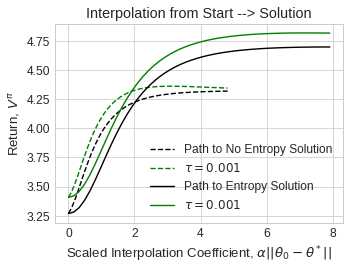

In [12]:
plt.figure(figsize=(5,4))
policy = Policy(mdp.state_space, mdp.action_space)
alpha, Vpi, Vpi_ent, _ = interpolate_between_policy_parameters(
  starting_parameters.detach(),
  no_ent_parameters.detach(),
  mdp,
  policy,
  w_ent=0.001,
  alpha_start=0.0,
  alpha_end=1.0)
plt.plot(
  alpha * no_ent_normalization, Vpi, label='Path to No Entropy Solution',
  linestyle='--', color='k')
plt.plot(
  alpha * no_ent_normalization , Vpi_ent, label=r'$\tau=0.001$',
  linestyle='--', color='g')

policy = Policy(mdp.state_space, mdp.action_space, mix_coeff=0.2)

alpha, Vpi,V_pi_ent, _ = interpolate_between_policy_parameters(
  starting_parameters.detach(),
  ent_parameters.detach(),
  mdp,
  policy,
  w_ent=0.001,
  alpha_start=0.0,
  alpha_end=1.0)

plt.plot(
  alpha * ent_normalization, Vpi, label='Path to Entropy Solution', color='k')
plt.plot(
  alpha * ent_normalization, V_pi_ent, label=r'$\tau=0.001$', color='g')


# plt.plot(alpha, Vpi_ent, label='Entropy 0.1')
plt.xlabel(r'Scaled Interpolation Coefficient, $\alpha ||\theta_0 - \theta^*||$')
plt.ylabel(r'Return, $V^\pi$')
plt.legend()
plt.title('Interpolation from Start --> Solution')

plt.tight_layout()


##### Interpolation between solutions

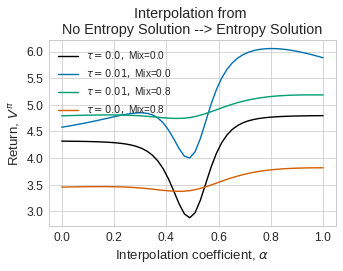

In [13]:
plt.figure(figsize=(5,4))

w_ent = 0.01
mix_coeff = 0.8

policy = Policy(mdp.state_space, mdp.action_space)

alpha, Vpi, Vpi_ent, _ = interpolate_between_policy_parameters(
  no_ent_parameters.detach(), ent_parameters.detach(), mdp, policy, 
  w_ent=w_ent, alpha_start=0.0, alpha_end=1.0)


plt.plot(alpha, Vpi, label=r'$\tau=0.0,$ Mix=0.0', color='k')
plt.plot(alpha, Vpi_ent, label=r'$\tau={},$ Mix=0.0'.format(w_ent))

policy = Policy(mdp.state_space, mdp.action_space, mix_coeff=mix_coeff)

alpha, V_pi_mix_only, Vpi_ent, _ = interpolate_between_policy_parameters(
  no_ent_parameters.detach(), ent_parameters.detach(), mdp, policy, 
  w_ent=w_ent, alpha_start=0.0, alpha_end=1.0)

plt.plot(alpha, Vpi_ent, label=r'$\tau={},$ Mix={}'.format(w_ent, mix_coeff))
plt.plot(alpha, V_pi_mix_only, label=r'$\tau=0.0,$ Mix={}'.format(mix_coeff))


plt.xlabel(r'Interpolation coefficient, $\alpha$')
plt.ylabel(r'Return, $V^\pi$')
plt.title('Interpolation from \nNo Entropy Solution --> Entropy Solution')
# plt.ylim(3.0, 5.0)
plt.legend(loc='upper left', fontsize='x-small')
plt.tight_layout()
# plt.savefig('no_ent_ent_combos_small_ent1.pdf')